PARTLY TAKEN FROM https://www.tensors.net/p-dmrg

In [1]:
# -*- coding: utf-8 -*-
"""
mainDMRG_MPO.py
---------------------------------------------------------------------
Script file for initializing the Hamiltonian of a 1D spin chain as an MPO \
before passing to the DMRG routine.

    by Glen Evenbly (c) for www.tensors.net, (v1.1) - last modified 19/1/2019
"""

#### Preamble
import numpy as np
from scipy import linalg as LA
import matplotlib.pyplot as plt

#from ncon import ncon
from tensornetwork.ncon_interface import ncon
from doDMRG_MPO_mine import doDMRG_MPO

import tensornetwork as tn
import math
from numpy import *

In [2]:
def createMPS(num):    
    c=[]
    for i in range(N):
        c.append(tn.Node(num[i]))
    for i in range(N-1):
        c[i][2] ^ c[i+1][0]
    return c

In [3]:
def conjMPS(mps):
    c=[]
    for i in range(N):
        c.append(tn.conj(mps[i]))
    for i in range(1,N-1):
        c[i][2] ^ c[i+1][0]
    return c

In [4]:
def rightcollapsePsiPsi(mps1,mps2,l):
    node = mps1[N-1] @ mps2[N-1]
    for i in range(N-2,l-1,-1):
        node = mps1[i] @ node
        node = node @ mps2[i]
    return node.tensor

In [5]:
def getrhoin(num,k):
    mps2 = createMPS(num)
    mps1 = conjMPS(mps2)
    for i in range(N):
        mps1[i][1] ^ mps2[i][1]
    tensor4 = rightcollapsePsiPsi(mps1,mps2,k+1)
    if k==N-2:
        matrix = tensor4[:,0,:,0]
    else:
        matrix = tensor4[:,0,0,:]
    return matrix

In [6]:
def calcEntrdiag(rhoin):
    diagrhoin = np.diag(np.diag(rhoin))
    lndiagrhoin = LA.logm(diagrhoin)
    entr = -np.trace(np.dot(diagrhoin,lndiagrhoin))
    return entr

In [7]:
def calcEntrsing(rhoin):
    u,s,vh = LA.svd(rhoin, full_matrices=False)
    smatrix = np.diag(s)
    lnsmatrix = LA.logm(smatrix)
    entr = -np.trace(np.dot(smatrix,lnsmatrix))
    return entr

In [8]:
def calcEntrsvd(num):
    mps=createMPS(A)
    node = mps[0]
    for i in range(1,N):
        node = node @ mps[i]
    psi = node.tensor
    entr = []
    for k in range(1,N):
        psi = psi.reshape((chid**k,chid**(N-k)))
        u,s,vh = LA.svd(psi, full_matrices=False)
        summ = 0
        for i in range(len(s)):
            mod2 = s[i]*np.conj(s[i])
            summ += mod2 * np.log(mod2)
        summ = -summ
        entr.append(summ)
    return entr

In [9]:
def printEntr(num):
    #entrdiag=[]
    #entrsing=[]
    #for k in range(N-1):
        #rhoin = getrhoin(num,k)
        #entrdiag.append(calcEntrdiag(rhoin))
        #entrsing.append(calcEntrsing(rhoin))
        #print('Entanglement entropy ( position = ',k,'):',np.real(np.around(entrdiag[k],decimals=acc)))
        #print('Entanglement entropy ( position = ',k,'):',np.real(entrdiag[k]))
    arange = np.arange(N-1)
    entr = calcEntrsvd(num)
    f = plt.figure(figsize=(18, 10))
    #plt.scatter(arange, entrdiag, s=50, marker='o', color='IndianRed')
    #diff=[]
    #for i in range(N-1):
        #diff.append(entrdiag[i] - entrsing[i])
    #plt.plot(arange, entrdiag, 'bs',label="Entanglement entropy from diagonalized rho_in")
    #plt.plot(arange, diff, 'r^',label="The difference between entanglement entropy from diagonalized rho_in and entanglement entropy from singular values matrix of rho_in")
    plt.plot(arange, entr, 'bs')
    #plt.legend()
    plt.xlabel("Position", fontsize=20)
    plt.ylabel("Entanglement Entropy", fontsize=20)
    #plt.yscale('log')
    plt.axis('tight')
    plt.show()

In [10]:
def func(loc):
    #print('h =',h)
    global chi
    #### Define Hamiltonian MPO (quantum XX model)
    chid = 2
    sX = 0.5*np.array([[0, 1], [1, 0]])
    sZ = 0.5*np.array([[1, 0], [0,-1]])
    sI = np.array([[1, 0], [0, 1]])
    M = np.zeros([3,3,chid,chid]);
    M[0,0,:,:] = sI
    M[1,0,:,:] = sZ
    M[2,0,:,:] = h*sZ + g*sX
    M[2,1,:,:] = -sZ
    M[2,2,:,:] = sI

    ML = np.array([0,0,1]).reshape(3,1,1) #left MPO boundary
    MR = np.array([1,0,0]).reshape(3,1,1) #right MPO boundary

    #### Initialize MPS tensors
    A = [0 for x in range(N)]
    A[0] = np.random.rand(1,chid,min(chi,chid))
    for k in range(1,N):
        A[k] = np.random.rand(A[k-1].shape[2],chid,min(min(chi,A[k-1].shape[2]*chid),chid**(N-k-1)))

    #### Do DMRG sweeps (2-site approach)
    En1, A, sWeight, B = doDMRG_MPO(A,ML,M,MR,chi, numsweeps = OPTS_numsweeps, dispon = OPTS_dispon, updateon = OPTS_updateon, maxit = OPTS_maxit, krydim = OPTS_krydim)

    #### Increase bond dim and reconverge
    chi = 32;
    En2, A, sWeight, B = doDMRG_MPO(A,ML,M,MR,chi, numsweeps = OPTS_numsweeps, dispon = OPTS_dispon, updateon = OPTS_updateon, maxit = OPTS_maxit, krydim = OPTS_krydim)

    #printEntr(A)
    
    mps=createMPS(A)
    node = mps[0]
    for i in range(1,N):
        node = node @ mps[i]
    psi = node.tensor
    psi = psi.reshape((chid**loc,chid**(N-loc)))
    u,s,vh = LA.svd(psi, full_matrices=False)
    summ = 0
    for i in range(len(s)):
        mod2 = s[i]*np.conj(s[i])
        summ += mod2 * np.log(mod2)
    summ = -summ
    return summ

The length of the Ising spin chain: 12
H = - ZZ + hZ + gX
Z = 0.5*sigmaZ
X = 0.5*sigmaX
g = 1.05

Entanglement entropy for different values of h:
h = 0.0 : 0.08131738140448613
h = 0.1 : 0.06777069674145803
h = 0.2 : 0.0455953389238118
h = 0.3 : 0.029594887666358313
h = 0.4 : 0.01964254033017319
h = 0.5 : 0.013444491246744834
h = 0.6 : 0.009465105007868882
h = 0.7 : 0.006826217801092318
h = 0.8 : 0.00502509854769146
h = 0.9 : 0.003764926715167234
h = 1.0 : 0.002864262860837315


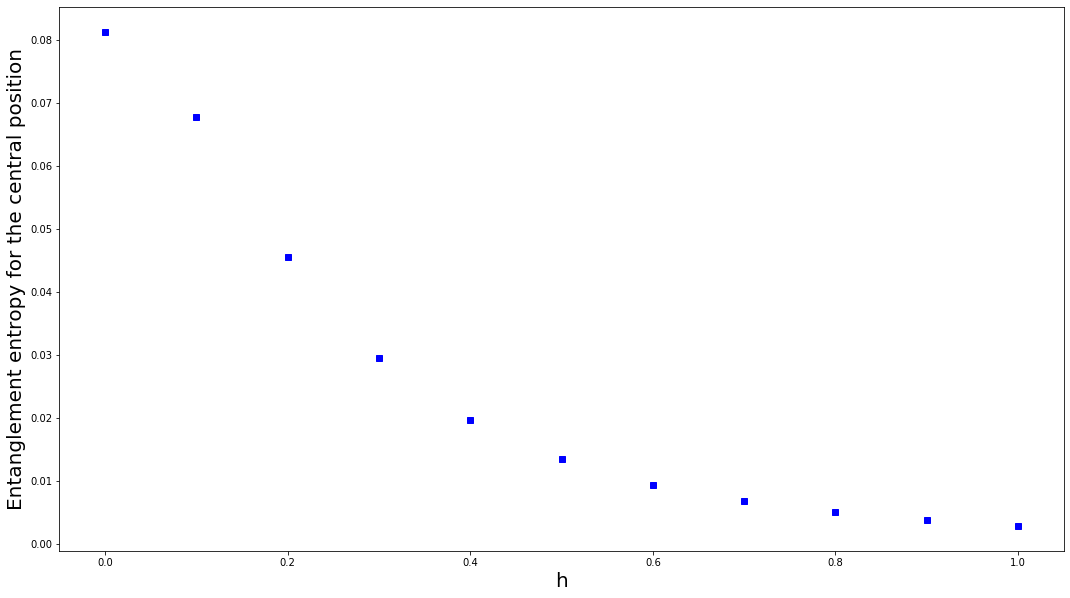

h = 0.5

Entanglement entropy for different positions:
Position =  0 :  0.020884181535073872
Position =  1 :  0.015191556419183462
Position =  2 :  0.013792863140106575
Position =  3 :  0.01350884788807707
Position =  4 :  0.013453394214570832
Position =  5 :  0.01344448848638674
Position =  6 :  0.01345335172065787
Position =  7 :  0.013509070622610746
Position =  8 :  0.013809489132147485
Position =  9 :  0.015192497047748372
Position =  10 :  0.020884179367881846


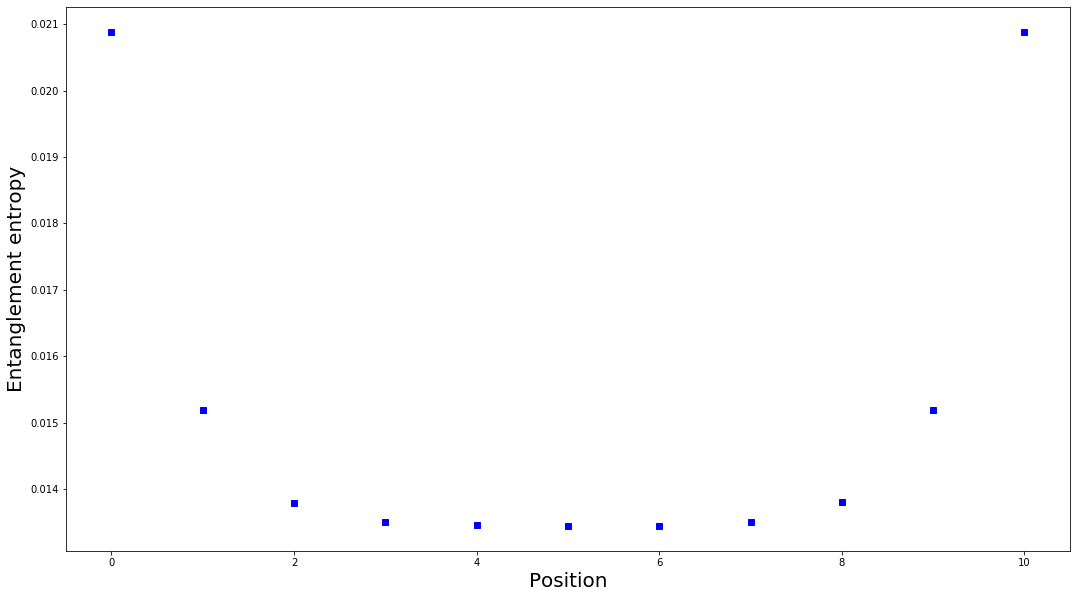

In [12]:
##### -ZZ+hZ+gX model #############
#######################################

##### Set bond dimensions and simulation options
chi = 16;
N = 12;
print('The length of the Ising spin chain:',N)
print('H = - ZZ + hZ + gX')
print('Z = 0.5*sigmaZ')
print('X = 0.5*sigmaX')
g = 1.05
print('g =',g)

OPTS_numsweeps = 4 # number of DMRG sweeps
OPTS_dispon = 0 # level of output display
OPTS_updateon = True # level of output display
OPTS_maxit = 2 # iterations of Lanczos method
OPTS_krydim = 4 # dimension of Krylov subspace

acc = 6

print()
print('Entanglement entropy for different values of h:')

entr = []
for it in range(11):
    h = it/10
    entr.append(func(N//2))
    print('h =',h,':',entr[it])
    
arange = linspace(0, 1, N-1)
#print(arange)

f = plt.figure(figsize=(18, 10))
plt.plot(arange, entr, 'bs')
#plt.legend()
plt.xlabel("h", fontsize=20)
plt.ylabel("Entanglement entropy for the central position", fontsize=20)
#plt.yscale('log')
plt.axis('tight')
plt.show()


entrloc = []
h=0.5
print('h =',h)
print()
print('Entanglement entropy for different positions:')
for it in range(1,N):
    entrloc.append(func(it))
    print('Position = ', it-1,': ',entrloc[it-1])
    
arange = np.arange(N-1)
#print(arange)

ff = plt.figure(figsize=(18, 10))
plt.plot(arange, entrloc, 'bs')
#plt.legend()
plt.xlabel("Position", fontsize=20)
plt.ylabel("Entanglement entropy", fontsize=20)
#plt.yscale('log')
plt.axis('tight')
plt.show()